In [1]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
from skimage.transform import resize
from PIL import Image
from io import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
import statistics
import matplotlib.pyplot as plt;

In [2]:
#Der Header funkt
HEADERS = {'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36',
            'Accept-Language': 'en-US, en;q=0.5'}

2 Verschiedene "Modi":
- 1  Automatisches Erstellen der Listen anhand von Keyword und Referenzprodukt
- 2 Bearbeitung (Score assessment) existierender CSVs

In [3]:
Modi=2 #1 oder 2
Path_CSV=r"C:\Users\Nikol\Desktop\contrastive_dataset.csv"

In [4]:
#1:
if Modi==1:
    Keywords=["Haarschere"]
    #Titel des Ref. Produkts (muss noch angepasst werden auf Liste von Links..)
    Ref_prod="Haarschere Premium Friseurscheren, Lidasen Scharfe Licht Ausdünnen Haarschneideschere, Edelstahl Friseurschere Profi Frisörschere mit Etui, Perfekter Effilierschere für Damen und Herren"
    #Soups der Result pages
    Result_soups = [BeautifulSoup(requests.get("https://www.amazon.de/s?k="+keyw.replace(" ", "+"), headers=HEADERS).text, "html5lib") for keyw in Keywords]
    #Gibt Listen der ASINs und Titel der Produkte wieder
    def Get_items(soups):
        urls=[]
        Titles=[]
        ASINs=[]
        for soup in soups:
            for Prod_q in soup.select("a.a-link-normal.a-text-normal"):
                Prod=Prod_q.select('span.a-size-base-plus.a-color-base.a-text-normal')
                if Prod!=[]:
                    Titles.append(Prod[0].get_text())
                    hreff=re.search("(?<=dp).*", Prod_q.find_parent().find(name="a")["href"]).group(0)
                    if hreff[0]=="%":
                        ASINs.append(hreff.split("%")[1][2:])
                    else:
                        ASINs.append(hreff.split("/")[1])
        return Titles, ASINs
    #Listen der Titel und ASINs 
    Titles, ASINs=Get_items(Result_soups)

#2:
elif Modi==2:
    Dataset=pd.read_csv(Path_CSV, index_col="ASIN")
    ASINs=list(Dataset.index)
    Titles=list(Dataset.Title)
    Ref_prod=list(Dataset[Dataset.Comment=="Referenz"].Title)[0]

#urls=["https://www.amazon.de/dp/"+ ASIN for ASIN in ASINs]

In [5]:
#Provisorische Blacklist. Elemente aus dieser Liste werden aus den Titeln entfernt.
Clean_prov=[",", "/", "(", ")", "|", ".", "- "]

#Entfernt Strings die in "Clean_prov" enthalten sind aus den Titeln
#Und Gibt Listen der übrigen Wörter wieder: "Titel(,) Test" -> ["Titel", "Test"]
def Clean_wordlister(Title, Clean=Clean_prov):
    for elem in Clean:
        Title=Title.replace(elem, "")
    #return list(dict.fromkeys(Title.lower().split(" ")))
    return list(filter(None, list(dict.fromkeys(Title.lower().split(" ")))))

#Wendet Clean_wordlister auf den Referenztitel und die Vergleichstitel
#der Results an und speichert diese Listen in Clean_ref & Clean_Titles
Clean_ref=Clean_wordlister(Ref_prod)
Clean_Titles=[]
for elem in Titles:
    Title=Clean_wordlister(elem)
    Clean_Titles.append(Title)

#Für jedes Wort im Titel des Referenzprodukts das im zum vergleichenden Produkttitel vorkommt
#+1 Score, Geteilt durch die Anzahl der Wörter, d.h. max. Score = 1
def Assess_products(titles=Clean_Titles, ref=Clean_ref):
    Scores=np.zeros((len(titles)))
    for elem in ref:
        for i in range(len(titles)):
            for j in range(len(titles[i])):
                if elem==titles[i][j]:
                    Scores[i]+=1
    return [Scores[i]/len(Clean_Titles[i]) for i in range(len(Clean_Titles))]
#Dataset["EasyScore"]=Assess_products()

In [6]:
#Produktbilder
Session = requests.Session()
Session.headers.update({
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_3) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.0.5 Safari/605.1.15"
})
def get_product_image(ASINs, session=Session):
    response = session.get(f"https://www.amazon.de/dp/{ASINs}")
    soup = BeautifulSoup(response.text, "html.parser")
    image_url = soup.find("div", {"id": "imgTagWrapperId"}).find("img").get("data-old-hires")
    image = Image.open(BytesIO(requests.get(image_url).content))
    image = np.array(image)
    return resize(image, (256, 256, 3))
#Wortvektoren
embedding = hub.KerasLayer(
    "https://tfhub.dev/google/nnlm-de-dim128-with-normalization/2", 
    input_shape=[],
    dtype=tf.string)
#Bildung der Wortvektoren anhand der Clean_Titles
#Embeddings werden in einem Dictionary gespeichert, um embedding so wenig wie möglich zu callen
def Embedd_Titles_W(Title_List=Clean_Titles):
    Embeddeds={}
    Ordered_Emb=[]
    for i in range(len(Title_List)):
        Ordered_Emb.append([])
        for j in Title_List[i]:
            if j not in Embeddeds.keys():
                Embeddeds[j]=embedding([j])
            Ordered_Emb[i].append(Embeddeds[j])
    return Ordered_Emb, Embeddeds
Clean_Ref_Emb=Embedd_Titles_W(Clean_ref)[0]
Ord_Emb, Embeddeds=Embedd_Titles_W(Clean_Titles)
#Verschiedene Metriken der Vektoren
def Euclid(word1, word2):
    return np.linalg.norm(Embeddeds[word1]-Embeddeds[word1])
def Euclid1(Embedd1, Embedd2):
    return np.linalg.norm(Embedd1-Embedd2)
def Manhattan(word1, word2):
    return np.sum(np.abs(Embeddeds[word1]-Embeddeds[word2]))
def Manhattan1(Embedd1, Embedd2):
    return np.sum(np.abs(Embedd1-Embedd2))
def Maximums(word1, word2):
    return np.max(np.abs(Embeddeds[word1]-Embeddeds[word2]))
def Maximums1(Embedd1, Embedd2):
    return np.max(np.abs(Embedd1-Embedd2))
#def Cos_Sim(word1, word2):
def Vec_Score(Ordered_Emb=Ord_Emb, Clean_Ref=Clean_Ref_Emb):
    Scores_Euclid=[]
    Scores_Manhattan=[]
    Scores_Maximums=[]
    Scores_Cos=[]
    for emb in Ordered_Emb:
        Temp_Scores=[[],[],[],[]]
        for elem in emb:
            for ref in Clean_Ref:
                Temp_Scores[0].append(Euclid1(elem, ref))
                Temp_Scores[1].append(Manhattan1(elem, ref))
                Temp_Scores[2].append(Maximums1(elem, ref))
                #Temp_Scores[3].append(Cos_Sim(elem, ref))
        Scores_Euclid.append(np.sum(Temp_Scores[0])/len(emb))
        Scores_Manhattan.append(np.sum(Temp_Scores[1])/len(emb))
        Scores_Maximums.append(np.sum(Temp_Scores[2])/len(emb))
    return Scores_Euclid, Scores_Manhattan, Scores_Maximums

In [7]:
Euc, Man, Maxi=Vec_Score()
Dataset["Euclid"]=(Euc-np.mean(Euc))*1/np.std(Euc)
Dataset["Manhattan"]=(Man-np.mean(Man))*1/np.std(Man)
Dataset["MaxMet"]=(Maxi-np.mean(Maxi))*1/np.std(Maxi)

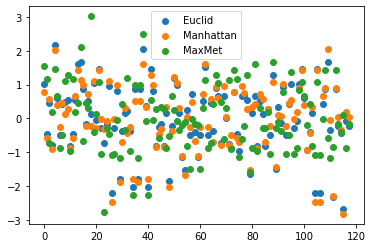

In [8]:
for i in range(-3, 0, 1):
    plt.scatter(range(len(Dataset.iloc[:, i])), Dataset.iloc[:, i], label=list(Dataset.columns.values.tolist())[i])
    plt.legend()